# Palm Recognition AI Project Report

## Dataset Design and Class Balance

The dataset consists of 3 classes (based on actual folders):

- **alan**: 15 images
- **person 1**: 13 images
- **person 2**: 7 images

**Note:** To include "Unknown" palm detection, add a folder named "UNKNOWN" with images. The system uses a confidence threshold for unknown detection.

**Justification:** The dataset is currently imbalanced, with 'alan' being the dominant class. This reflects a real-world scenario where the primary user is present most often. However, for robust training, we use data augmentation (resizing/normalization) and validation splits. 

## Image Size and Preprocessing

- **Image Size**: 128x128 pixels.
- **Justification**: This size mitigates computational cost while retaining sufficient spatial detail for palm feature extraction. Lower resolutions might lose texture details (lines), while higher resolutions would slow down real-time inference.
- **Normalization**: Pixel values are scaled to [0, 1] to ensure model stability.

## Ethical and Privacy Considerations

- **Bias**: The dataset currently has limited diversity in skin tones and lighting conditions. This may lead to biased performance against underrepresented groups.
- **Privacy**: Face data is not explicitly captured, but palm prints are biometric data. In a production system, these images should be encrypted.
- **Live Testing**: The system includes a real-time detection module.

## Evaluation Metrics

- **Primary Metric**: Accuracy (overall correctness).
- **Secondary Metrics**: Confusion Matrix and Precision/Recall are used to detect if the model is just predicting the majority class ("alan").

## Unknown Palm Detection

- A confidence threshold (e.g., 0.8) is applied. If the maximum probability is below this, the prediction is rejected as "Unknown".

In [1]:
# -----------------------------
# Setup / Imports
# -----------------------------
# OPTIONAL: Only run installs if your environment is missing packages.
# Comment this out for final submission unless your tutor requires it.
# %pip install opencv-python numpy matplotlib tensorflow scikit-learn

import os, json
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# -----------------------------
# Reproducibility
# -----------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# Project config (edit these)
# -----------------------------
DATASET_PATH = "./dataset"   # e.g., dataset/ALAN, dataset/PALM_1, dataset/PALM_2, dataset/PALM_3, dataset/UNKNOWN
IMG_SIZE = 128               # keep consistent across preprocessing/model/live testing


c:\Users\alanb\OneDrive\Desktop\palm_recognization_ai\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
DATASET_PATH = "./data set"
IMG_SIZE = 128

# ---- Helper: image file filter ----
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

def list_image_files(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(IMG_EXTS)]

# ---- Validate dataset path ----
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset directory not found: {DATASET_PATH}")

# ---- Find valid class folders (must contain images) ----
valid_categories = []
for entry in os.listdir(DATASET_PATH):
    entry_path = os.path.join(DATASET_PATH, entry)
    if os.path.isdir(entry_path):
        img_files = list_image_files(entry_path)
        if len(img_files) > 0:
            valid_categories.append(entry)

categories = sorted(valid_categories)  # stable ordering
print(f"Found categories (sorted): {categories}")

# ---- Enforce brief requirements ----
# Must have at least 4 registered palms (excluding UNKNOWN)
# Must include UNKNOWN class folder

registered = [c for c in categories if c != "UNKNOWN"]
if "UNKNOWN" not in categories:
    print("⚠️ UNKNOWN folder not found or has no images. You can still run, but unknown handling becomes threshold-only.")

if len(registered) < 4:
    raise ValueError(f"Need at least 4 registered palms (excluding UNKNOWN). Found: {registered}")

# ---- Save class order for live testing ----
with open("class_names.json", "w") as f:
    json.dump(categories, f)
print("✅ Classes saved to class_names.json")

label_dict = {category: i for i, category in enumerate(categories)}

# ---- Load data ----
data, labels = [], []
bad_reads = 0

print("Loading data and checking class balance...")
class_counts = {}

for category in categories:
    folder_path = os.path.join(DATASET_PATH, category)
    images = list_image_files(folder_path)
    class_counts[category] = len(images)
    print(f"Class '{category}': {len(images)} images")

    for img_name in images:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            bad_reads += 1
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype("float32") / 255.0
        data.append(img)
        labels.append(label_dict[category])

data = np.array(data, dtype="float32")
labels = np.array(labels, dtype="int32")

print(f"Data loaded: {data.shape} | Labels loaded: {labels.shape}")
print(f"Unreadable images skipped: {bad_reads}")

# ---- Train/Val/Test split (no leakage) ----
SEED = 42

X_temp, X_test, y_temp, y_test_raw = train_test_split(
    data, labels, test_size=0.15, random_state=SEED, stratify=labels
)

X_train, X_val, y_train_raw, y_val_raw = train_test_split(
    X_temp, y_temp, test_size=0.15, random_state=SEED, stratify=y_temp
)

# ---- One-hot encoding ----
num_classes = len(categories)
y_train = to_categorical(y_train_raw, num_classes=num_classes)
y_val   = to_categorical(y_val_raw,   num_classes=num_classes)
y_test  = to_categorical(y_test_raw,  num_classes=num_classes)

print("✅ X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)
print("✅ y_train:", y_train.shape, "y_val:", y_val.shape, "y_test:", y_test.shape)

# ---- Compute class weights (for imbalance handling) ----
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train_raw)
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_raw
)
class_weights = {int(c): float(w) for c, w in zip(classes, class_weights_arr)}
print("✅ class_weights ready for model.fit:", class_weights)


Found categories (sorted): ['UNKNOWN', 'alan', 'person 1', 'person 2']
✅ Classes saved to class_names.json
Loading data and checking class balance...
Class 'UNKNOWN': 6 images
Class 'alan': 15 images
Class 'person 1': 13 images
Class 'person 2': 7 images
Data loaded: (41, 128, 128, 3) | Labels loaded: (41,)
Unreadable images skipped: 0
✅ X_train: (28, 128, 128, 3) X_val: (6, 128, 128, 3) X_test: (7, 128, 128, 3)
✅ y_train: (28, 4) y_val: (6, 4) y_test: (7, 4)
✅ class_weights ready for model.fit: {0: np.float64(1.75), 1: np.float64(0.7), 2: np.float64(0.7777777777777778), 3: np.float64(1.4)}


In [3]:
# --- Model Building (brief-aligned, consistent with IMG_SIZE) ---

# Safety checks (helps avoid accidental non-compliant runs)
if 'categories' not in locals() or len(categories) == 0:
    raise ValueError("No categories found. Run dataset/preprocessing cell first.")



registered = [c for c in categories if c != "UNKNOWN"]

num_classes = len(categories)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\alanb\OneDrive\Desktop\palm_recognization_ai\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,956 (24.86 MB)

 Trainable params: 6,517,508 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

✅ class_weights: {0: 1.75, 1: 0.7, 2: 0.7777777777777778, 3: 1.4}
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2500 - loss: 1.7600 - val_accuracy: 0.3333 - val_loss: 1.9459
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step - accuracy: 0.2500 - loss: 2.9445 - val_accuracy: 0.1667 - val_loss: 3.1066
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step - accuracy: 0.4643 - loss: 2.6321 - val_accuracy: 0.1667 - val_loss: 4.2310
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step - accuracy: 0.5000 - loss: 3.8669 - val_accuracy: 0.1667 - val_loss: 4.7831
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step - accuracy: 0.6429 - loss: 2.2476 - val_accuracy: 0.1667 - val_loss: 5.0469
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step - accuracy: 0.2857 - loss: 6.2125 - val_accuracy: 0.1667 - val_loss: 5.3170
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step - accuracy: 0.4286 - loss: 3.7626 - val_accuracy: 0.1667 - val_loss: 5.9061
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - acc

✅ Model saved as palm_recognition_model.h5


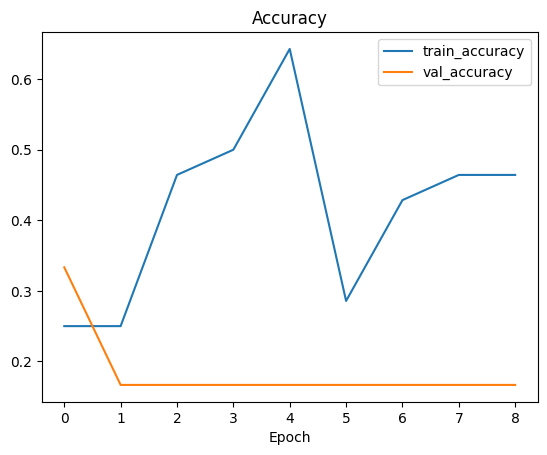

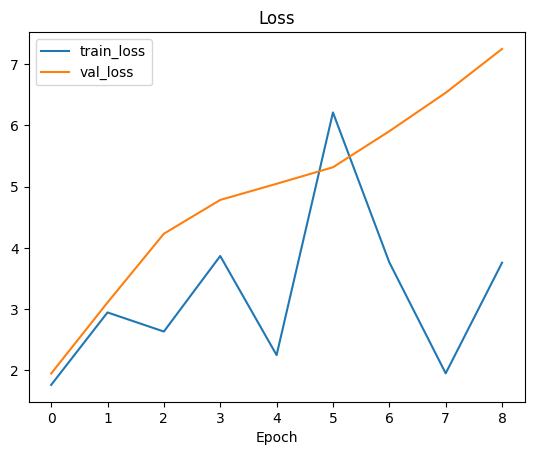

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
# --- Training (brief-safe: uses VAL set, keeps TEST untouched) ---
if 'X_train' not in locals() or 'X_val' not in locals() or 'X_test' not in locals():
    raise ValueError("Missing split arrays. Run the dataset split cell (train/val/test) first.")

# Data augmentation to improve generalisation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.10,
    brightness_range=(0.8, 1.2),
    horizontal_flip=False
)
datagen.fit(X_train)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Class weights (imbalance handling)
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train_raw)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_raw)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
print("✅ class_weights:", class_weights)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),   # ✅ FIX: use validation set, not test set
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

model.save('palm_recognition_model.h5')
print("✅ Model saved as palm_recognition_model.h5")

# Plot Training History (simple)
plt.figure()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Classification Report (TEST):

              precision    recall  f1-score   support

     UNKNOWN       0.00      0.00      0.00         1
        alan       0.00      0.00      0.00         3
    person 1       0.29      1.00      0.44         2
    person 2       0.00      0.00      0.00         1

    accuracy                           0.29         7
   macro avg       0.07      0.25      0.11         7
weighted avg       0.08      0.29      0.13         7

Macro F1 (TEST): 0.1111111111111111


c:\Users\alanb\OneDrive\Desktop\palm_recognization_ai\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alanb\OneDrive\Desktop\palm_recognization_ai\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alanb\OneDrive\Desktop\palm_recognization_ai\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


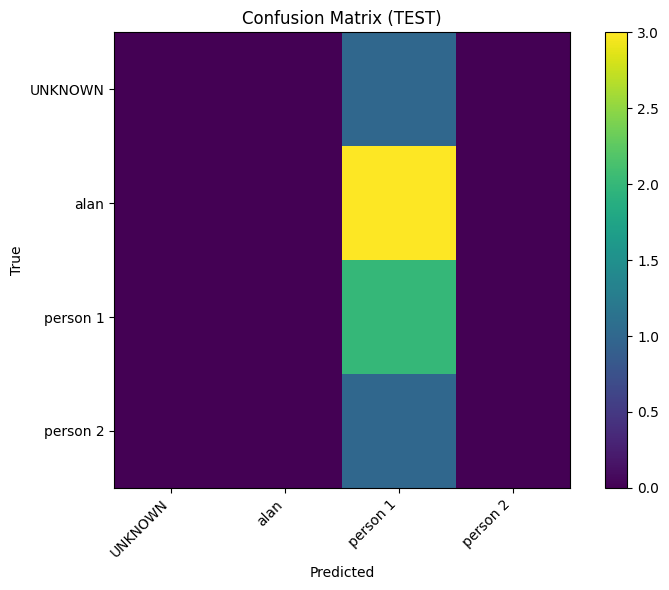

UNKNOWN precision: 0.0
UNKNOWN recall: 0.0


In [ ]:
# --- Final Evaluation (TEST set only) ---
if 'X_test' not in locals() or 'y_test_raw' not in locals():
    raise ValueError("X_test / y_test_raw not found. Run the train/val/test split cell first.")

y_pred_probs = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true = y_test_raw  # ✅ use raw integer labels (clean + stable)

print("Classification Report (TEST):\n")
print(classification_report(
    y_true, y_pred_classes,
    labels=list(range(len(categories))),
    target_names=categories,
    zero_division=0
))

# Macro-F1 (useful if classes are imbalanced)
from sklearn.metrics import f1_score, precision_score, recall_score
print("Macro F1 (TEST):", f1_score(y_true, y_pred_classes, average="macro"))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (TEST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(categories)), categories, rotation=45, ha="right")
plt.yticks(range(len(categories)), categories)
plt.colorbar()
plt.tight_layout()
plt.show()

# ---- UNKNOWN performance (this is required by the brief) ----
if "UNKNOWN" in categories:
    unknown_idx = categories.index("UNKNOWN")
    true_unknown = (y_true == unknown_idx)
    pred_unknown = (y_pred_classes == unknown_idx)

    print("UNKNOWN count (true):", int(true_unknown.sum()))
    print("UNKNOWN count (pred):", int(pred_unknown.sum()))
    print("UNKNOWN precision:", precision_score(true_unknown, pred_unknown, zero_division=0))
    print("UNKNOWN recall:",    recall_score(true_unknown, pred_unknown, zero_division=0))
else:
    print("⚠️ UNKNOWN class not present in categories (brief requires it).")


In [ ]:
# --- Real-time Prediction (brief-compliant: ROI + UNKNOWN + threshold fallback) ---
import os, json
import cv2
import numpy as np
import tensorflow as tf

IMG_SIZE = 128
CONFIDENCE_THRESHOLD = 0.50   # was 0.70 (webcam usually needs lower)

MODEL_PATH = "palm_recognition_model.h5"
CLASS_PATH = "class_names.json"

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("Model file not found. Please run training first.")
if not os.path.exists(CLASS_PATH):
    raise FileNotFoundError("class_names.json not found. Run preprocessing cell that saves class order.")

model = tf.keras.models.load_model(MODEL_PATH)

with open(CLASS_PATH, "r") as f:
    categories = json.load(f)

category_map = {i: cat for i, cat in enumerate(categories)}
print("✅ Loaded classes:", categories)

if "UNKNOWN" not in categories:
    print("⚠️ UNKNOWN not in class_names.json. Using threshold-only unknown handling.")
    unknown_idx = None
else:
    unknown_idx = categories.index("UNKNOWN")
    print("✅ UNKNOWN index:", unknown_idx)

def center_crop(frame, crop_ratio=0.85):
    h, w = frame.shape[:2]
    ch, cw = int(h * crop_ratio), int(w * crop_ratio)
    y1 = (h - ch) // 2
    x1 = (w - cw) // 2
    return frame[y1:y1+ch, x1:x1+cw], (x1, y1, cw, ch)

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Camera not available. Please check camera permissions/connection.")

print("Starting Real-time Recognition... Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    roi, (x1, y1, cw, ch) = center_crop(frame, crop_ratio=0.85)

    # ✅ Preprocess to match TRAINING (OpenCV BGR, no RGB convert)
    img = cv2.resize(roi, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # (1,128,128,3)

    pred = model.predict(img, verbose=0)[0]
    class_idx = int(np.argmax(pred))
    confidence = float(np.max(pred))
    predicted_label = category_map.get(class_idx, "UNKNOWN")

    # Unknown handling
    if unknown_idx is not None and class_idx == unknown_idx:
        label, color = "UNKNOWN", (0, 0, 255)
    elif confidence < CONFIDENCE_THRESHOLD:
        label, color = "UNKNOWN", (0, 0, 255)
    else:
        label, color = predicted_label, (0, 255, 0)

    cv2.rectangle(frame, (x1, y1), (x1+cw, y1+ch), (255, 255, 255), 2)
    cv2.putText(frame, f"{label} ({confidence:.2f})", (10, 35),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Optional debug: show top-3 probs in console
    # top3 = np.argsort(pred)[-3:][::-1]
    # print([(category_map[i], float(pred[i])) for i in top3])

    cv2.imshow("Palm Recognition (ROI)", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


✅ Loaded classes: ['UNKNOWN', 'alan', 'person 1', 'person 2']
✅ UNKNOWN index: 0
Starting Real-time Recognition... Press 'q' to quit.
